In [1]:
import pandas as pd
import numpy as nps
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from darts import TimeSeries
from darts.models import TFTModel
import torch
freq='2H3T14S'

In [2]:
def load_dataset(training_file, testing_file):
    dataframes = []
    for data_file in [training_file, testing_file]:
        parser = lambda data_string: datetime.strptime(data_string, '%Y-%m-%d %H:%M:%S')
#         dataframe = pd.read_csv(data_file)
        dataframe = pd.read_csv(data_file, parse_dates=['Time'],
                                date_parser=parser)
        print(f"Rows in {data_file}: {len(dataframe)}")
        dataframe.drop(['Ls', 'LT', 'CO2ice'], axis=1, inplace=True)
#         dataframe.index.name = "Time"

        # if data_file == training_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = True
        # elif data_file == testing_file:
        #     dataframe[TRAINING_FLAG_COLUMN] = False

        dataframes.append(dataframe)

    return pd.concat(dataframes, axis=0)

In [3]:
dataframe = load_dataset('../data/data_files/insight_openmars_training_time.csv',
                         '../data/data_files/insight_openmars_test_time.csv')
dataframe.head()

/tmp/ipykernel_1788/1492825542.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


Rows in ../data/data_files/insight_openmars_training_time.csv: 72196
Rows in ../data/data_files/insight_openmars_test_time.csv: 16364


/tmp/ipykernel_1788/1492825542.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataframe = pd.read_csv(data_file, parse_dates=['Time'],


,Time,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
0,1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1,1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
2,1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
3,1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
4,1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


In [4]:
# df_time_indexed = dataframe.set_index('Time')
time = pd.date_range("1998-07-15 21:23:39", periods=len(dataframe), freq=freq)
dataframe.index = time
dataframe = dataframe.drop(['Time'], axis=1)
dataframe.head()

,Tsurf,Psurf,cloud,vapour,u_wind,v_wind,dust,temp
1998-07-15 21:23:39,264.042,721.113,0.092,0.027,-7.451,8.604,0.428,179.686
1998-07-15 23:26:53,274.736,705.090,0.145,0.026,-7.053,4.934,0.427,174.502
1998-07-16 01:30:07,265.939,700.691,0.105,0.026,-6.825,-0.063,0.427,173.429
1998-07-16 03:33:21,238.624,697.252,0.134,0.025,-5.373,-4.048,0.426,173.556
1998-07-16 05:36:35,213.634,717.146,0.139,0.026,-3.899,-3.133,0.426,174.789


<Axes: xlabel='time'>

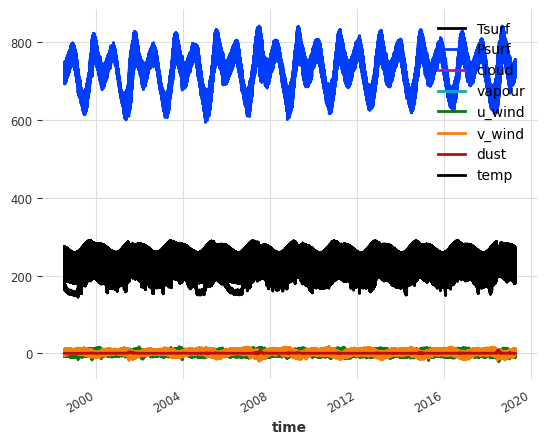

In [5]:
series = TimeSeries.from_dataframe(dataframe, time_col=None, value_cols=None, fill_missing_dates=True, freq='7394S', fillna_value=None)
series.plot()

<Axes: xlabel='time'>

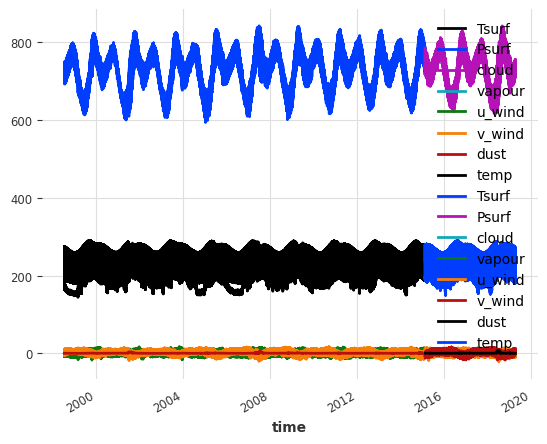

In [6]:
train_series, val_series = series.split_before(0.80)
train_series.plot()
val_series.plot()

In [7]:

from darts.metrics import rmse

# We first set aside the first 80% as training series:

def eval_model(model, series, past_covariates=None, future_covariates=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=12)
    
    series.plot()
    backtest.plot(label='predictions')
    print('Predictions RMSE = {}'.format(rmse(series, backtest)))
    return backtest

In [8]:

from darts.models import BlockRNNModel

brnn_no_cov = BlockRNNModel(input_chunk_length=24, 
                            output_chunk_length=12, 
                            n_rnn_layers=2)

brnn_no_cov.fit(train_series, 
                epochs=2, 
                verbose=True,
                past_covariates = series
                )



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.4 K 
4 | fc            | Sequential       | 2.5 K 
---------------------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.019     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=24, output_chunk_length=12)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Predictions RMSE = 105.18629423006877


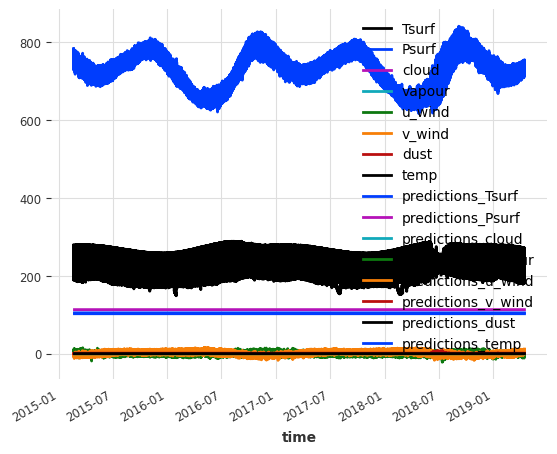

In [11]:
backtest = eval_model(brnn_no_cov, val_series)

In [13]:
brnn_no_cov.save('../model_files/LSTNET/blockrnn.pt')

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='time'>

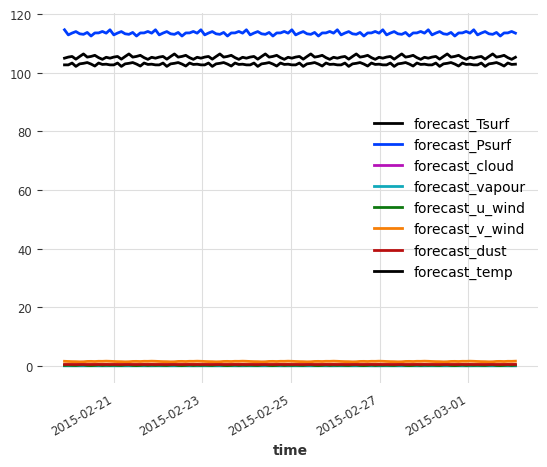

In [22]:
pred = brnn_no_cov.predict(n=120)

pred.plot(label='forecast')

In [23]:
rmse(series, pred)

108.95760878702421

In [16]:
import mlflow

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("MLflow Quickstart")
params = {
    'input_chunk_length':24, 
                            'output_chunk_length':12, 
                            'n_rnn_layers':2,
                            'epochs': 2
    
}
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("rmse", rmse(series, backtest))

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "BlockRNN model")

    # Infer the model signature

    # Log the model
    mlflow.log_artifact('../model_files/LSTNET/blockrnn.pt')



In [ ]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go
import pandas as pd
import os

# Sample data
actual_data = pd.read_csv('./data/test_data.csv', index_col = 0)
predicted_data_dict = {}
for predicted_data_file in os.listdir('./data/predicted_data/'):
    model_name = predicted_data_file.split('.')[0]
    predicted_data_dict[model_name] = pd.read_csv(f'./data/predicted_data/{predicted_data_file}', index_col = 0)

print(predicted_data_dict)

# Initialize the Dash app
app = dash.Dash(__name__)

# Define the layout
model_names_dropdown_dict = {}
model_names_dropdown_list = []
for model_name in predicted_data_dict.keys():
    model_name_new = '_'.join(model_name.split('_')[3:])
    model_names_dropdown_list.append({'label': model_name_new, 'value': model_name})

variables = actual_data.columns.values.tolist()
variables_dropdown = []

print(variables)

for var in variables:
    variables_dropdown.append({'label': var, 'value': var})
app.layout = html.Div([
    html.Label('Select a model:'),
    dcc.Dropdown(
        id='dropdown-model',
        options=model_names_dropdown_list,
        value=model_names_dropdown_list[0]['value']  # Default selected value
    ),
    

    html.Label('Select a variable:'),
    dcc.Dropdown(
        id='dropdown-variable',
        options=variables_dropdown,
        value=variables[0]  # Default selected value
    ),

    dcc.Graph(id='line-plot')
])

# Define callback to update the line plot based on dropdown selections
@app.callback(
    Output('line-plot', 'figure'),
    [Input('dropdown-model', 'value'),
     Input('dropdown-variable', 'value')]
)
def update_line_plot(selected_model, selected_variable):
    print(f'selected model is {selected_model}, slected variable is {selected_variable}')
    fig = go.Figure()

    fig.add_trace(go.Scatter(
            x=actual_data.index,
            y=actual_data[selected_variable],
            marker=dict(
                color="blue"
            ),
            name='Actual',
            visible = True
            # visible=(column == default_column)

        ))

        # add line / trace 2 to figure
    fig.add_trace(go.Scatter(
        x=predicted_data_dict[selected_model].index,
        y=predicted_data_dict[selected_model].loc[:, selected_variable],
        marker=dict(
            color="red"
        ),
        name='Predicted',
        visible= True
    ))

    # if selected_variable == 'temp':
    #     variable_data = model_1_temp if selected_model == 'model_1' else model_2_temp
    # elif selected_variable == 'pressure':
    #     variable_data = model_1_pressure if selected_model == 'model_1' else model_2_pressure
    # else:
    #     # Handle other variables as needed
    #     variable_data = []
    model_short_name = '_'.join(selected_model.split('_')[3:])
   
    # fig.add_trace(go.Scatter(x=[1, 2, 3], y=variable_data, mode='lines+markers', name=f'{selected_model}_{selected_variable}'))
    fig.update_layout(
    title_text=f'{selected_variable.capitalize()} Plot for model - {model_short_name}',
    height=800

    )
    # fig.update_layout(
    #     title=f'{selected_model} {selected_variable.capitalize()} Plot',
    #     xaxis_title='Time',
    #     yaxis_title=selected_variable.capitalize(),
    # )
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         step="day",
                         stepmode="backward"),
                    dict(count=1,
                         step="month",
                         stepmode="backward"),
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
        )
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, host = '0.0.0.0',use_reloader=False, port = 8054)  # Turn off reloader if inside Jupyter

